In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
import os
print(os.environ['GOOGLE_API_KEY'][:10]+'*'*10)

AIzaSyC06D**********


In [4]:
from langchain_teddynote import logging

logging.langsmith("Naive RAG TEST")

LangSmith 추적을 시작합니다.
[프로젝트명]
Naive RAG TEST


In [7]:
# from langchain_core.prompts import ChatPromptTemplate
# from langchain import hub

# prompt_txt = """
# You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. 
# Your primary mission is to answer questions based on provided context or chat history.
# Ensure your response is concise and directly addresses the question without any additional narration.

# ###

# You may consider the previous conversation history to answer the question.

# # Here's the previous conversation history:
# {chat_history}

# ###

# Your final answer should be written concisely (but include important numerical values, technical terms, jargon, and names), followed by the source of the information.

# # Steps

# 1. Carefully read and understand the context provided.
# 2. Identify the key information related to the question within the context.
# 3. Formulate a concise answer based on the relevant information.
# 4. Ensure your final answer directly addresses the question.
# 5. List the source of the answer in bullet points, which must be a file name (with a page number) or URL from the context. Omit if the answer is based on previous conversation or if the source cannot be found.

# # Output Format:
# [Your final answer here, with numerical values, technical terms, jargon, and names in their original language]

# **Source**(Optional)
# - (Source of the answer, must be a file name(with a page number) or URL from the context. Omit if the answer is based on previous conversation or can't find the source.)
# - (list more if there are multiple sources)
# - ...

# ###

# Remember:
# - It's crucial to base your answer solely on the **provided context** or **chat history**. 
# - DO NOT use any external knowledge or information not present in the given materials.
# - If a user asks based on the previous conversation, but if there's no previous conversation or not enough information, you should answer that you don't know.

# ###

# # Here is the user's question:
# {question}

# # Here is the context that you should use to answer the question:
# {context}

# # Your final answer to the user's question:
# """

# prompt = ChatPromptTemplate.from_template(prompt_txt)
# hub.push("naive_rag_gemni", prompt)

In [5]:
from langchain_core.prompts import load_prompt
from langchain_core.output_parsers import StrOutputParser
from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings

from abc import ABC, abstractmethod
from operator import itemgetter
from langchain import hub


class RetrievalChain(ABC):
    def __init__(self):
        self.source_uri = None
        self.k = 10

    @abstractmethod
    def load_documents(self, source_uris):
        """loader를 사용하여 문서를 로드합니다."""
        pass

    @abstractmethod
    def create_text_splitter(self):
        """text splitter를 생성합니다."""
        pass

    def split_documents(self, docs, text_splitter):
        """text splitter를 사용하여 문서를 분할합니다."""
        return text_splitter.split_documents(docs)

    def create_embedding(self):
        return OllamaEmbeddings(model="bge-m3")
    
    def create_embdding_eng(self):
        return GoogleGenerativeAIEmbeddings(model="text-embedding-004")

    def create_vectorstore(self, split_docs, inlang = "ko"):
        if inlang == "ko":
            return FAISS.from_documents(
                documents=split_docs, embedding=self.create_embedding()
            )
        elif inlang == "eng":
            return FAISS.from_documents(
                documents=split_docs, embedding=self.create_embdding_eng()
            )

    def create_retriever(self, vectorstore):
        # MMR을 사용하여 검색을 수행하는 retriever를 생성합니다.
        dense_retriever = vectorstore.as_retriever(
            search_type="similarity", search_kwargs={"k": self.k}
        )
        return dense_retriever

    def create_model(self):
        # return ChatOllama(model_name="dnotitia/dna", temperature=0)
        return ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)

    def create_prompt(self):
        return hub.pull("naive_rag_gemni")

    @staticmethod
    def format_docs(docs):
        return "\n".join(docs)

    def create_chain(self, inlang = "ko"):
        docs = self.load_documents(self.source_uri)
        text_splitter = self.create_text_splitter()
        split_docs = self.split_documents(docs, text_splitter)
        self.vectorstore = self.create_vectorstore(split_docs, inlang)
        self.retriever = self.create_retriever(self.vectorstore)
        model = self.create_model()
        prompt = self.create_prompt()
        self.chain = (
            {
                "question": itemgetter("question"),
                "context": itemgetter("context"),
                "chat_history": itemgetter("chat_history"),
            }
            | prompt
            | model
            | StrOutputParser()
        )
        return self

In [6]:
from langchain_community.document_loaders import PDFPlumberLoader, PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing import List, Annotated


class PDFRetrievalChain(RetrievalChain):
    def __init__(self, source_uri: Annotated[str, "Source URI"]):
        self.source_uri = source_uri
        self.k = 10

    def load_documents(self, source_uris: List[str]):
        docs = []
        for source_uri in source_uris:
            # loader = PDFPlumberLoader(source_uri)
            loader = PyPDFLoader(source_uri)
            docs.extend(loader.load())

        return docs

    def create_text_splitter(self):
        return RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

In [7]:
# PDF 문서를 로드합니다.
pdf = PDFRetrievalChain(["../data/2025 KB 부동산 보고서.pdf"]).create_chain(inlang="ko")

# retriever와 chain을 생성합니다.
pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

In [8]:
search_result = pdf_retriever.invoke("2024년 부동산 시장 트렌드는?")
print('\n\n'.join([doc.page_content for doc in search_result]))

1 
2024 KB 부동산 보고서: 2024년 주택시장 진단과 전망 
 
 
 
Executive Summary 1 
 2025년 주택시장 하향 안정, 정부 정책 방향이 중요한 한 해가 될 전망 
주택시장은 2022년 하반기 이후 상승과 하락을 반복하는 상황이 지속되고 있다. 이러한 시장 흐름은 
올해도 이어질 것으로 보인다. 높은 가격에 대한 부담, 대출 규제 등의 하락 요인과 함께 공급 부족, 금리 인하 
등의 상승 요인이 혼재되어 있기 때문이다. 다만, 선호도에 따른 지역별 차별화 현상은 더욱 확대될 수 있다.   
올해 주택시장의 가장 큰 변수는 정부의 정책이 될 가능성이 높다. 지난해 하반기 시장 흐름에서 볼 수 
있듯이, 실수요자 중심인 현재의 주택시장에서 대출 규제의 영향은 상당히 크다. 올해 주택시장의 또 다른 
변수는 주택 공급이 될 수 있다. 공사비 증가, 부동산 프로젝트파이낸싱(PF) 시장 경색으로 민간 공급이

2 
2024 KB 부동산 보고서: 2024년 주택시장 진단과 전망 
 
 
 
Executive Summary 2 
 2025년 주택시장 전망은 하락 의견이 우세, 올해 하반기 또는 내년 반등 예상  
• 주택 매매가격은 비수도권은 하락 전망, 수도권은 의견이 엇갈림 
2025년 전국 주택 매매가격에 대해 부동산전문가(62%), 공인중개사(79%), 자산관리전문가(PB, 62%) 모두 
하락 전망이 우세하였다. 지역별로 보면 비수도권에 대해서는 하락 전망으로 의견이 일치하였으나 
수도권에 대해서는 조사 집단별로 의견이 엇갈렸다. 부동산전문가는 상승 전망이 54%로, 공인중개사는 
하락 전망이 56%로 다소 우세하였다.  
• 2025년 하반기 또는 2026년 수도권 주택 경기 회복 기대 
수도권 주택 경기 회복 시기에 대해 부동산전문가는 2025년 하반기(36%)와 2026년(38%)이 비슷한

4 
2024 KB 부동산 보고서: 2024년 주택시장 진단과 전망 
 
  
 
 
Contents 
 
Ⅰ. 2025년 주택시장 

In [9]:
# 검색 결과를 기반으로 답변을 생성합니다.
answer = pdf_chain.invoke(
    {
        "question": "2024년 부동산 시장 트렌드는?",
        "context": search_result,
        "chat_history": [],
    }
)
print(answer)

2024년 주택시장은 상승과 하락을 반복하며 혼란스러운 양상을 보였으며, 연초 하락세를 이어가다 2분기 이후 서울과 수도권 일부 지역 중심으로 가파르게 상승, 9월 이후 정부의 가계부채 관리 강화 방안 발표 이후 하락세로 전환되었습니다. 2024년 주택 매매 거래량은 64.2만 호로 전년 대비 15.8% 증가했지만, 직전 10년 평균의 66.0% 수준에 불과했습니다. 2024년 주택 전세가격은 전년 대비 1.4% 상승했습니다. 2025년 주택시장의 주요 변수는 공급과 정책이며, 전문가들은 2025년 하반기 또는 2026년 수도권 주택 경기 회복을 기대하고 있습니다.

**Source**
- ../data/2025 KB 부동산 보고서.pdf (page 6)
- ../data/2025 KB 부동산 보고서.pdf (page 7)
- ../data/2025 KB 부동산 보고서.pdf (page 11)
- ../data/2025 KB 부동산 보고서.pdf (page 2)
- ../data/2025 KB 부동산 보고서.pdf (page 35)


In [10]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)

In [11]:
def format_docs(docs):
    return "\n".join(
        [
            f"<document><content>{doc.page_content}</content><source>{doc.metadata['source']}</source><page>{int(doc.metadata['page'])+1}</page></document>"
            for doc in docs
        ]
    )


def format_searched_docs(docs):
    return "\n".join(
        [
            f"<document><content>{doc['content']}</content><source>{doc['url']}</source></document>"
            for doc in docs
        ]
    )


def format_task(tasks):
    # 결과를 저장할 빈 리스트 생성
    task_time_pairs = []

    # 리스트를 순회하면서 각 항목을 처리
    for item in tasks:
        # 콜론(:) 기준으로 문자열을 분리
        task, time_str = item.rsplit(":", 1)
        # '시간' 문자열을 제거하고 정수로 변환
        time = int(time_str.replace("시간", "").strip())
        # 할 일과 시간을 튜플로 만들어 리스트에 추가
        task_time_pairs.append((task, time))

    # 결과 출력
    return task_time_pairs


In [12]:
from langchain_teddynote.messages import messages_to_history


# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = pdf_retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return {"context": retrieved_docs}


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }

In [13]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)

# 엣지 정의
workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 컴파일
app = workflow.compile(checkpointer=memory)

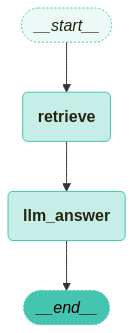

In [14]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

In [15]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="2024년 부동산 시장 트렌드는?")

# 그래프 실행
invoke_graph(app, inputs, config)


🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>1 
2024 KB 부동산 보고서: 2024년 주택시장 진단과 전망 
 
 
 
Executive Summary 1 
 2025년 주택시장 하향 안정, 정부 정책 방향이 중요한 한 해가 될 전망 
주택시장은 2022년 하반기 이후 상승과 하락을 반복하는 상황이 지속되고 있다. 이러한 시장 흐름은 
올해도 이어질 것으로 보인다. 높은 가격에 대한 부담, 대출 규제 등의 하락 요인과 함께 공급 부족, 금리 인하 
등의 상승 요인이 혼재되어 있기 때문이다. 다만, 선호도에 따른 지역별 차별화 현상은 더욱 확대될 수 있다.   
올해 주택시장의 가장 큰 변수는 정부의 정책이 될 가능성이 높다. 지난해 하반기 시장 흐름에서 볼 수 
있듯이, 실수요자 중심인 현재의 주택시장에서 대출 규제의 영향은 상당히 크다. 올해 주택시장의 또 다른 
변수는 주택 공급이 될 수 있다. 공사비 증가, 부동산 프로젝트파이낸싱(PF) 시장 경색으로 민간 공급이</content><source>../data/2025 KB 부동산 보고서.pdf</source><page>2</page></document>
<document><content>2 
2024 KB 부동산 보고서: 2024년 주택시장 진단과 전망 
 
 
 
Executive Summary 2 
 2025년 주택시장 전망은 하락 의견이 우세, 올해 하반기 또는 내년 반등 예상  
• 주택 매매가격은 비수도권은 하락 전망, 수도권은 의견이 엇갈림 
2025년 전국 주택 매매가격에 대해 부동산전문가(62%), 공인중개사(79%), 자산관리전문가(PB, 62%) 모두 
하락 전망이 우세하였다. 지역별로 보면 비수도권에 대해서는 하락 전망으로 의견이 일치하였으나 
수도권에 대해서는 조사 집단별로 의견이 엇갈렸다. 부동산전문가는 상승 전망이 54%로, 공인중개사는 
하

In [16]:
# 그래프를 스트리밍 출력
stream_graph(app, inputs, config)


🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
2024년 주택시장은 상승과 하락을 반복하는 혼조세가 나타났으며, 하락-상승-하락으로 이어지며 시장 방향성에 대한 혼란이 가중되었습니다. 2024년 주택 매매 거래량은 64.2만 호로 전년 대비 15.8% 증가했지만, 2012~2021년 평균의 66.0% 수준에 불과했습니다. 2024년 주택 전세가격은 전년 대비 1.4% 상승했습니다.

**Source**
- ../data/2025 KB 부동산 보고서.pdf, page 7
- ../data/2025 KB 부동산 보고서.pdf, page 8

In [17]:
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Question: 2024년 부동산 시장 트렌드는?
Answer:
2024년 주택시장은 상승과 하락을 반복하는 혼조세가 나타났으며, 하락-상승-하락으로 이어지며 시장 방향성에 대한 혼란이 가중되었습니다. 2024년 주택 매매 거래량은 64.2만 호로 전년 대비 15.8% 증가했지만, 2012~2021년 평균의 66.0% 수준에 불과했습니다. 2024년 주택 전세가격은 전년 대비 1.4% 상승했습니다.

**Source**
- ../data/2025 KB 부동산 보고서.pdf, page 7
- ../data/2025 KB 부동산 보고서.pdf, page 8
